In [210]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline.load import load_data
from reproduction import analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
OPENS = "../data/open-recs/*.tfrecord"
CLOSEDS = "../data/closed-recs/*.tfrecord"
CENTERS = "../output/m15b-enc.cluster_centres"
ENCODER_DEF = "../output/mod09cnn15b/encoder.json"
ENCODER_WEIGHTS = "../output/mod09cnn15b/encoder-585000.h5"
ENCODINGS = "../output/mod09cnn15b/m15b-enc"

In [132]:
centers = analysis.read_kmeans_centers(CENTERS)

In [133]:
k = KMeans(n_clusters=centers.shape[0], init=centers)

In [5]:
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

In [6]:
opens = analysis.AEData(load_data(OPENS, encoder.input_shape[1:]), n=5000)
closeds = analysis.AEData(load_data(CLOSEDS, encoder.input_shape[1:]), n=5000)

In [7]:
opens.add_encoder(encoder)
closeds.add_encoder(encoder)

In [134]:
k.cluster_centers_ = centers

In [135]:
o = k.predict(opens.encs)
c = k.predict(closeds.encs)

In [21]:
o.shape

(5000,)

In [28]:
opens.encs.shape

(5000, 128)

In [177]:
both = np.append(opens.encs,closeds.encs, axis=0)

clusters_km = k.predict(both)
clusters_km2 = KMeans(n_clusters=60).fit_predict(both)
clusters_km3 = KMeans(n_clusters=60).fit_predict(both)
clusters_ag = AgglomerativeClustering(n_clusters=60).fit_predict(both)

In [199]:
clusters_sc = SpectralClustering(n_clusters=60, affinity="nearest_neighbors").fit_predict(both)
clusters_sc2 = SpectralClustering(n_clusters=60, affinity="nearest_neighbors").fit_predict(both)

In [185]:
perm = np.random.permutation(10000)
inv_perm = np.argsort(perm)

clusters_ag2 = AgglomerativeClustering(n_clusters=60).fit_predict(both[perm])
clusters_ag2 = clusters_ag2[inv_perm]


In [211]:
def compare_clusters(a, b):
    plt.figure(figsize=(5,4))
    h = plt.hist2d(a, b, bins=60, norm=LogNorm())
    plt.colorbar(h[3] )
    plt.xlabel("A")
    plt.ylabel("B")
    amis = sklearn.metrics.adjusted_mutual_info_score(a, b)
    plt.title("Adjusted information score %f"%amis)

(array([2539., 1753., 1192.,  454.,  425.,  714.,  902., 1004.,  461.,
         556.]),
 array([ 0. ,  5.9, 11.8, 17.7, 23.6, 29.5, 35.4, 41.3, 47.2, 53.1, 59. ]),
 <a list of 10 Patch objects>)

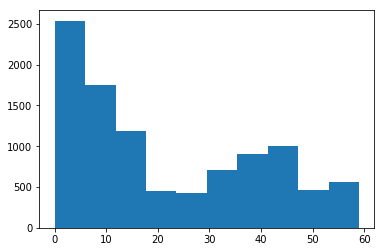

In [212]:
plt.hist(clusters_sc2)

/anaconda3/envs/clouds/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


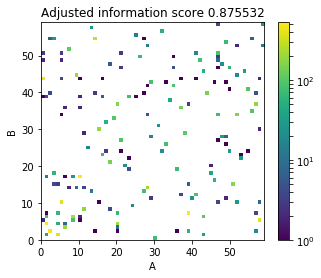

In [213]:
compare_clusters(clusters_sc, clusters_sc2)

In [125]:
o, c = clusters[:5000], clusters[5000:]

In [136]:
true_labels = np.zeros(10000)
true_labels[:5000] += 1

In [145]:
# Probability you correctly classify open vs closed given cluster assignments
correctness = 0
for i in range(60):
    # Add one open and closed cell to every class to increase uncertainty
    # in clusters with few examples
    n_open = np.where(o == i)[0].shape[0] + 1
    n_clos = np.where(c == i)[0].shape[0] + 1
    n_clus = n_open + n_clos
    
    prob_open = n_open / n_clus
    correctness += n_clus * max(prob_open, 1 - prob_open)
    
correctness /= 10000
correctness

0.6483

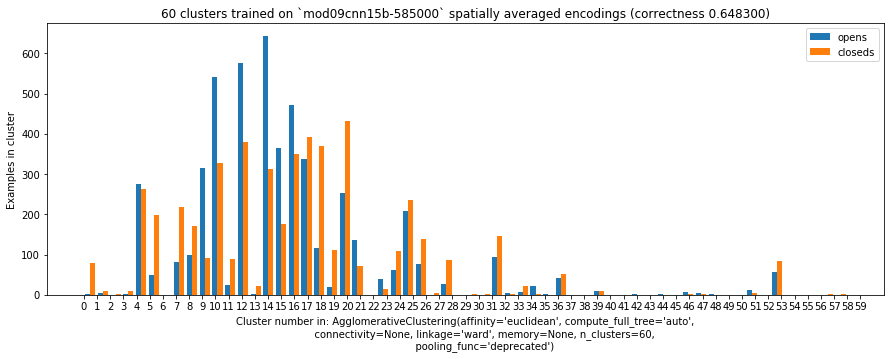

In [138]:
plt.figure(figsize=(15, 5))
# plt.hist(o, label="open", bins=bins, rwidth=0.4)
# plt.hist(c, alpha=0.5, label="closed", bins=bins, rwidth=0.5)
plt.hist([o,c], bins=60, label=["opens", "closeds"])
plt.xlabel("Cluster number in: "+str(ag))
plt.xticks(range(60))
plt.ylabel("Examples in cluster")
plt.title("60 clusters trained on `mod09cnn15b-585000` spatially averaged encodings (correctness %f)"% correctness)
plt.legend()

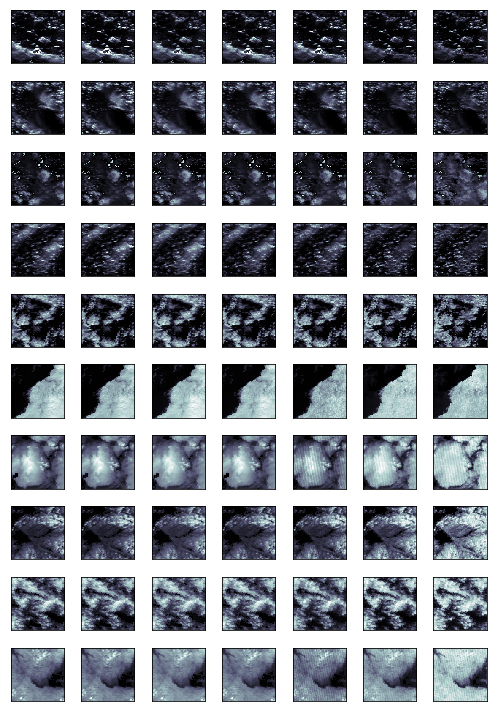

In [12]:
# THis is a bad result :( ^^^^
fig, ax = plt.subplots(10, 7, figsize=(7, 10))

for i in range(10):
    for j in range(7):
        a = ax[i,j]
        if i < 5:
            a.imshow(opens.imgs[o == 12][i,:,:,j], cmap="bone")
        else:
            a.imshow(closeds.imgs[c == 12][i,:,:,j], cmap="bone")
            
        a.set_xticks([]); a.set_yticks([])

fig.tight_layout()
# opens.imgs[o == 28].shape

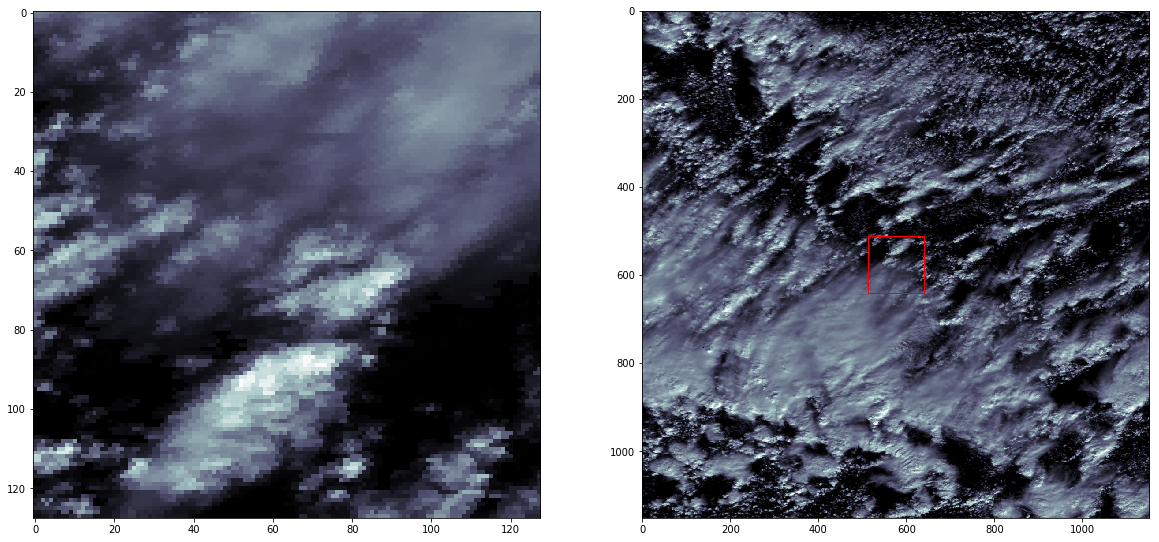

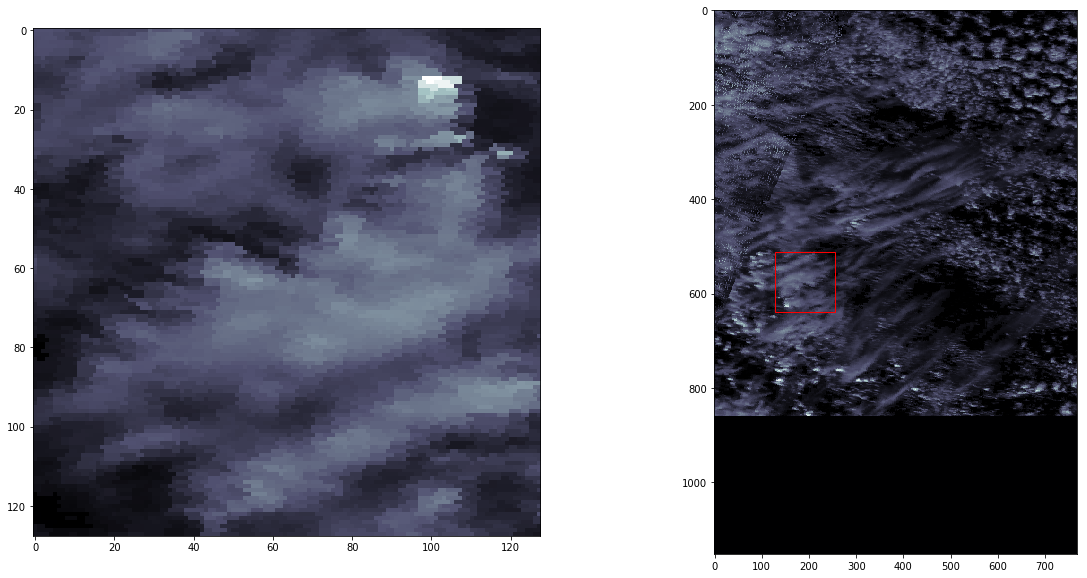

In [75]:
cluster = 9

i = np.argwhere(o == cluster)[0,0]
j = np.argwhere(c == cluster)[0,0]

opens.plot_neighborhood(i,context_width=512)
closeds.plot_neighborhood(j,context_width=512)